# Compare cost function across `n_bins` and `timedelta` in different seasons

Findings:
* Models with bad WLS can still look better than models with good WLS
* Fewer bins means lower WLS by construction
* No consistent patterns otherwise...

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
from itertools import product
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

import fields
import model

%matplotlib inline

## Read data and setup analysis

In [3]:
ds = xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc")
ds = ds.where(ds.time.dt.year > 2014, drop=True)

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var", "evi"]]


In [4]:
# Analysis variables
datasets = [ds_xco2, ds_sif]
covariates = [["lon", "lat"], ["evi"]]
timedeltas = np.array([0, -1, -2])
n_bins = np.arange(20, 45, 5)

In [5]:
def factor_analysis(timestamp: str, timedelta: int, n_bins: int):
    deltas = [0, timedelta]
    mod = model.FullBivariateMatern()
    mf = fields.MultiField(
        datasets, covariates, np.datetime64(timestamp), deltas
    )
    vario_config = fields.VarioConfig(max_dist = 1500, n_bins = n_bins)
    gamma = mf.empirical_variograms(vario_config)
    mod.fit(gamma)
    return mod.fit_result.cost

def apply_factor_analysis(timestamp: str, timedeltas: list, n_bins: np.ndarray) -> pd.DataFrame:
    df = pd.DataFrame(list(product(n_bins, timedeltas)), columns=["bin_count", "timedelta"])
    df["cost"] = df.apply(lambda row: factor_analysis(timestamp, row["timedelta"], row["bin_count"]), axis=1)
    return df.pivot("timedelta", "bin_count", "cost")

def analyze_month(month: int, timedeltas, n_bins):
    """Run factor analysis for the given month in 2016, 2018, and 2020"""
    if month < 10:
        timestamps = [f"{y}-0{month}-01" for y in [2016, 2018, 2020]]
    else:
        timestamps = [f"{y}-{month}-01" for y in [2016, 2018, 2020]]
    for timestamp in timestamps:
        print(f"Month: {timestamp}")
        df = apply_factor_analysis(timestamp, timedeltas, n_bins)
        _, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(df, ax=ax, annot=True)

## Winter

Month: 2016-02-01
Month: 2018-02-01
Month: 2020-02-01


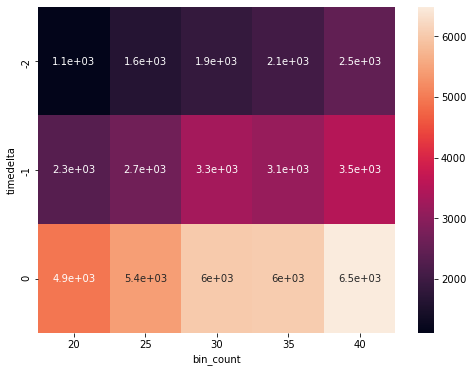

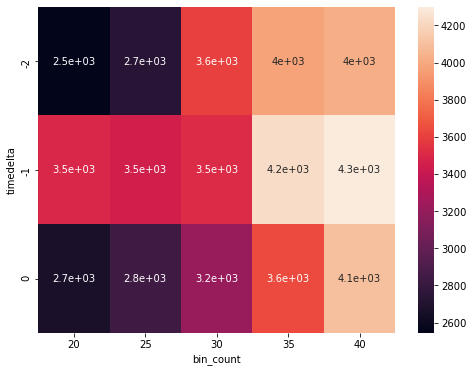

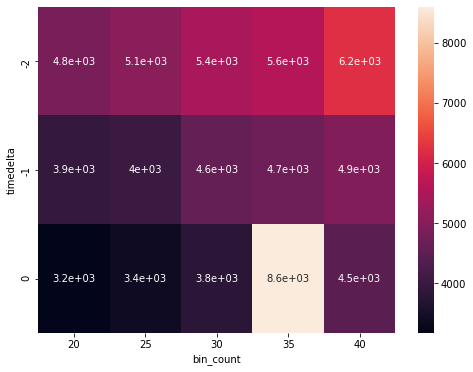

In [6]:
analyze_month(2, timedeltas, n_bins)

## Spring

Month: 2016-05-01
Month: 2018-05-01
Month: 2020-05-01


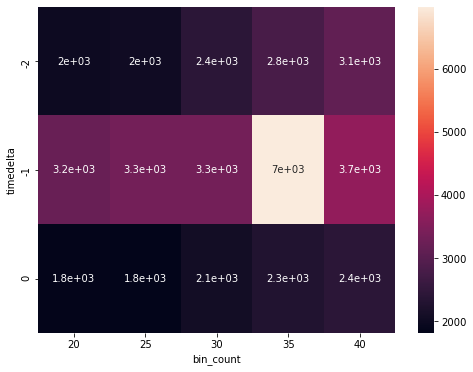

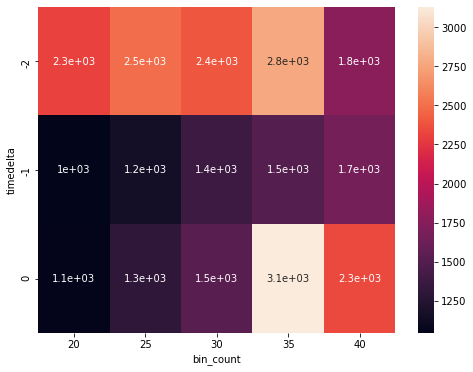

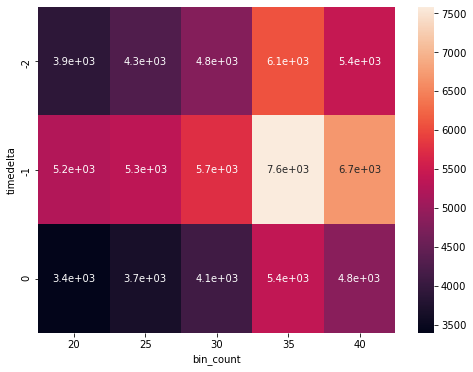

In [7]:
analyze_month(5, timedeltas, n_bins)

## Summer

Month: 2016-08-01
Month: 2018-08-01
Month: 2020-08-01


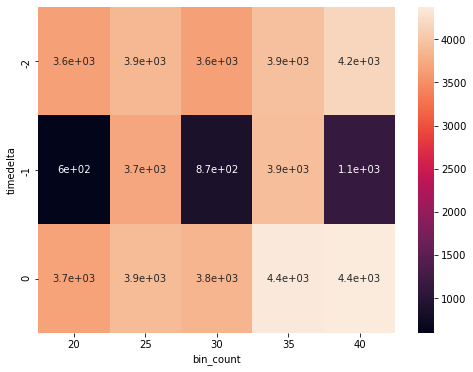

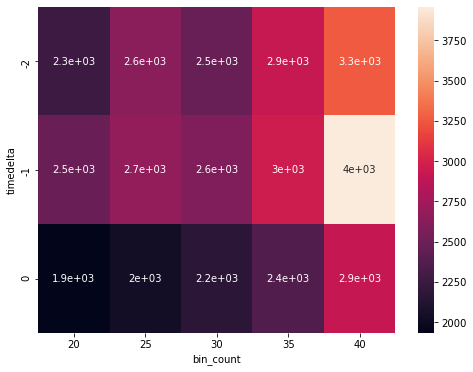

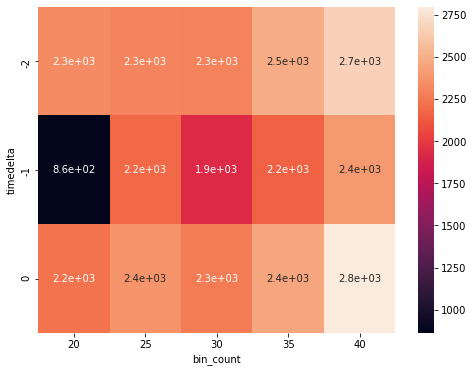

In [8]:
analyze_month(8, timedeltas, n_bins)

## Fall

Month: 2016-10-01
Month: 2018-10-01
Month: 2020-10-01


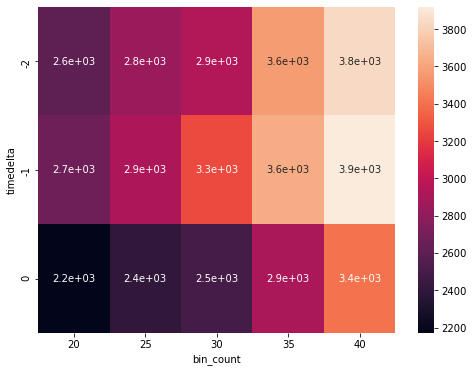

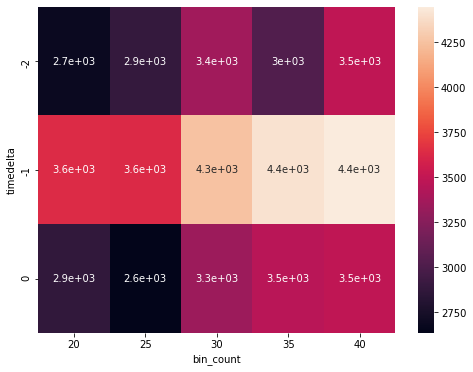

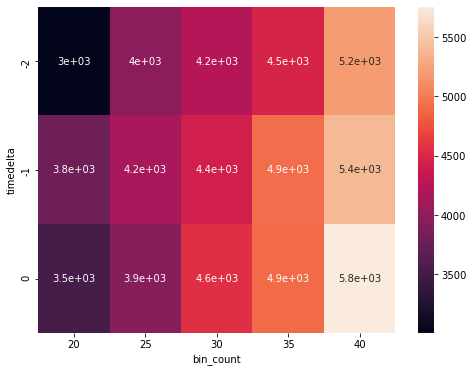

In [9]:
analyze_month(10, timedeltas, n_bins)

## After choosing `n_bins`, run factor analysis for timestamps vs. timedeltas